# [A continuous identity verification method based on free-text keystroke dynamics](http://ieeexplore.ieee.org.proxy1.lib.uwo.ca/document/7844242/authors)

In [2]:
import psycopg2
import pandas as pd
import sys
sys.path.append("..")
import credentials
from sqlalchemy import create_engine
engine = create_engine(credentials.postgres)
import numpy as np
from datetime import datetime
import time
import string
from tqdm import tnrange, tqdm_notebook, tqdm
import numpy.ma as ma
from multiprocessing import Pool
# This makes plots render inline

In [3]:
# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
# (can use `tqdm_gui`, `tqdm_notebook`, optional kwargs, etc.)
tqdm_notebook().pandas(desc="Progress")

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [4]:
% matplotlib inline

In [5]:
key_codes = pd.read_csv('key_codes.csv').set_index('code').key

In [6]:
# Basic Connection and Query
connection = engine.connect()

In [7]:
def get_sequence(user_id=None, limit=None, connection=connection, filter_alpha=False):
    people = {}
    # Calculate Dwells
    condition_text = 'WHERE user_id=\'%s\'' % user_id if user_id is not None else ''
    limit_text = 'LIMIT \'%s\'' % str(limit) if limit is not None else ''
    print("SELECT * FROM strokes %s ORDER BY key_time %s" % (condition_text, limit_text))
    result = connection.execute("SELECT * FROM strokes %s ORDER BY key_time %s" % (condition_text, limit_text)).fetchall()
    dwells = []
    for i in tnrange(len(result), desc='Loading'):
        row = result[i]
        row = (row[0], row[1], int(row[2]), int(row[3]), row[4])
        # Assure Users are in Dictionaries
        if row[0] not in people:
            people[row[0]] = {}
            
        if row[2] not in people[row[0]] and row[4] == 'd':
            people[row[0]][row[2]] = row[1]
        elif row[2] in people[row[0]] and row[4] == 'd':
            people[row[0]][row[2]] = row[1]
        elif row[2] in people[row[0]] and row[4] == 'u':
            dwell = row[1] - people[row[0]][row[2]]
            try:
                if not filter_alpha or (filter_alpha and key_codes[row[2]] in string.ascii_uppercase):
                    dwells.append({
                        'person': row[0],
                        'key_code': row[2],
                        'key': key_codes[row[2]],
                        'down': people[row[0]][row[2]],
                        'up': row[1],
                        'dwell': dwell
                    })
            except Exception as e:
                pass
                
            del(people[row[0]][row[2]])
    return pd.DataFrame(dwells).sort_values('down')


In [8]:
df = get_sequence(user_id='1d63b44d-a7cb-4ee6-b228-b0ff5b7d086f', filter_alpha=True)

SELECT * FROM strokes WHERE user_id='1d63b44d-a7cb-4ee6-b228-b0ff5b7d086f' ORDER BY key_time 


HBox(children=(IntProgress(value=0, description='Loading', max=615921), HTML(value='')))

In [ ]:
S = df.key
Interval = (df.shift(-1).down - df.up)
orderedInterval = Interval.sort_values().reset_index(drop=True)

In [ ]:
required = pd.DataFrame({i: Interval.shift(-i) for i in range(10)}).cummax(axis=1)
duration = pd.DataFrame({i: df.up.shift(-i) - df.down for i in range(10)})
keys = pd.DataFrame({i: df.key.shift(-i) for i in range(10)}).fillna('').progress_apply(lambda x: ['-'.join(x[:i+2]) for i in x.index], axis=1)

HBox(children=(IntProgress(value=0, description='Progress', max=175602), HTML(value='')))

In [ ]:
a = np.tile(orderedInterval[:-1],(1,1,1)).transpose()
Sa = np.tile(required, (1,1,1))

In [ ]:
def imap_unordered_bar(func, args, n_processes = 4):
    p = Pool(n_processes)
    res_list = []
    with tqdm_notebook(total = len(args)) as pbar:
        for i, res in tqdm_notebook(enumerate(p.imap_unordered(func, args))):
            pbar.update()
            res_list.append(res)
    pbar.close()
    p.close()
    p.join()
    return res_list

def get_counts(i):
    A = {}
    counter = i*n
    M = (Sa < a[i*n:n*(i+1)]).sum(2) - 1
    indexes = np.tile(M.transpose(), (1,1,1)).transpose()
    identity = np.tile(np.arange(10), (1, 1, 1))
    selected = np.not_equal(indexes, identity)
    ar = ma.array(seq, mask=selected)
    for i in ar:
        pairs, counts = np.unique(i.compressed(), return_counts=True)
        A[counter] = counts.mean()
        counter = counter + 1
    return A

In [ ]:
n = 50
k = np.array(keys)
seq = np.tile(k, (n,1,1))
result = imap_unordered_bar(get_counts, range(int(a.shape[0]/n)))

In [ ]:
A = {}
for d in result:
    A.update(d)

In [ ]:
orderedInterval.loc[orderedInterval < 1000].count()/orderedInterval.count()

In [ ]:
A = pd.Series(A)
A.plot()

In [ ]:
pd.DataFrame({'a': orderedInterval, 'Count': A}).loc[(orderedInterval<200) & (orderedInterval>-100)].set_index('a').dropna().plot()

In [116]:
A.to_csv('average_lengths.csv')

In [169]:
e = A.loc[A == A.max()].index[-1]
print('A: %s, E: %s' % (str(orderedInterval[e]), str(e)))

A: -15.0, E: 20875


In [170]:
M = (Sa < orderedInterval[e]).sum(2) - 1
indexes = np.tile(M.transpose(), (1,1,1)).transpose()
identity = np.tile(np.arange(10), (1, 1, 1))
selected = np.not_equal(indexes, identity)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [171]:
Am = pd.DataFrame({
    'A': ma.array(np.tile(k, (1,1,1)), mask=selected)[0].compressed(), 
    'T': ma.array(np.tile(np.array(duration), (1,1,1)), mask=selected)[0].compressed()
})

avg = Am.groupby('A').T.mean()
std = Am.groupby('A').T.std()
count = Am.groupby('A').T.count()

avg.to_csv('a_mean.csv')
std.to_csv('a_std.csv')
count.to_csv('a_count.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1244044a8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1246ffc88>]], dtype=object)

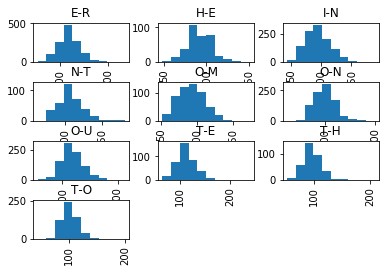

In [172]:
Am[Am.A.isin(count.sort_values(ascending=False).head(10).index)]['T'].hist(by=Am[Am.A.isin(count.sort_values(ascending=False).head(10).index)]['A'])

In [342]:
def get_user_seqs(user_id, limit=None):
    challenge = get_sequence(user_id=user_id, limit=limit, filter_alpha=True)
    Interval_challenge = (challenge.shift(-1).down - challenge.up)

    required_challenge = pd.DataFrame({i: Interval_challenge.shift(-i) for i in range(10)}).cummax(axis=1)
    duration_challenge = pd.DataFrame({i: challenge.up.shift(-i) - challenge.down for i in range(10)})
    keys_challenge = pd.DataFrame({i: challenge.key.shift(-i) for i in range(10)}).fillna('').progress_apply(lambda x: ['-'.join(x[:i+2]) for i in x.index], axis=1)

    M = (np.array(required_challenge) < orderedInterval[e]).sum(1) - 1
    indexes = np.tile(M.transpose(), (1, 1)).transpose()
    identity = np.tile(np.arange(10), (1, 1))
    selected = np.not_equal(indexes, identity)

    return pd.DataFrame({
        'A': ma.array(np.tile(np.array(keys_challenge), (1,1,1)), mask=selected)[0].compressed(), 
        'T': ma.array(np.tile(np.array(duration_challenge), (1,1,1)), mask=selected)[0].compressed()
    })

In [273]:
connor = Am

In [274]:
josh = get_user_seqs('e85b3844-5af0-47ea-bf51-62da4b4efc39')

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [275]:
BK = get_user_seqs('7bb179ed-9f9f-46ce-a403-57e88a92f216')

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [276]:
tony = get_user_seqs('62042708-5989-4bbf-a106-d7a66281b367')

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [377]:
connor_short = get_user_seqs('1d63b44d-a7cb-4ee6-b228-b0ff5b7d086f', limit=100)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [378]:
josh_short = get_user_seqs('e85b3844-5af0-47ea-bf51-62da4b4efc39', limit=100)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [379]:
connor_short.groupby('A').T.apply(get_distance).mean()

0.41715699362871383

In [380]:
josh_short.groupby('A').T.apply(get_distance).mean()

0.542572487710635

In [277]:
def get_distance(seq, avg=avg, std=std):
    if avg.get(seq.name) is None: return 0
    else: return np.exp(-np.square((seq-avg[seq.name]))/(2*np.square(std[seq.name]))).mean()

In [337]:
def diff_user(user):
    num = 10
    its = 1000
    samples = np.array([user.sample(num).groupby('A').T.apply(get_distance).mean() for i in tnrange(its)])
    print({
        'mean': samples.mean(),
        'min': samples.min(),
        'max': samples.max(),
        'std': samples.std()
    })
    return pd.Series(samples).hist()


{'mean': 0.73514328969266063, 'min': 0.40574558586552645, 'max': 0.9450331024070433, 'std': 0.087269735606724269}


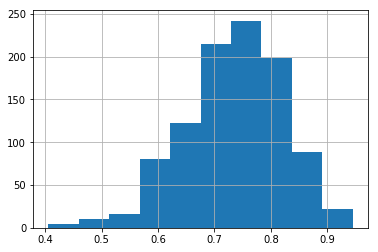

In [338]:
diff_user(connor)


{'mean': 0.4980951942194467, 'min': 0.1526508755013575, 'max': 0.922803662989365, 'std': 0.1217126803359196}


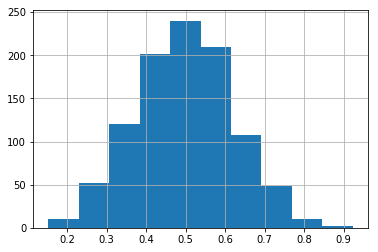

In [339]:
diff_user(josh)


{'mean': 0.50625267274143282, 'min': 0.13646013025942746, 'max': 0.90816998910067781, 'std': 0.13069734810185263}


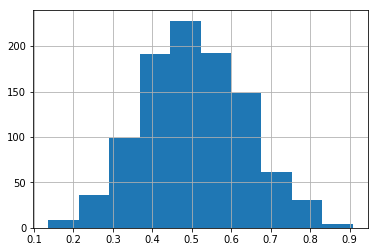

In [340]:
diff_user(BK)


{'mean': 0.27823177539685812, 'min': 0.0055322568067989412, 'max': 0.66145319638939015, 'std': 0.11088460762952421}


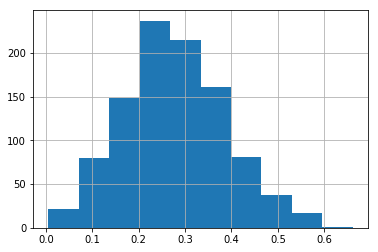

In [341]:
diff_user(tony)

In [332]:
seq_length = Am.A.apply(lambda x: len(x.split('-')))